In [217]:
# REQUIRED IMPORTS
# FILE MANAGEMENT
import h5py
import os
from IPython.utils import io

%load_ext autoreload
%autoreload 2

# DATA MANIPULATION
import numpy as np
import pandas as pd

# PALTAS FUNCTIONS
import network_predictions
import paltas
from paltas import generate

# STATISTICS
from scipy.stats import norm, truncnorm, uniform
import scipy.stats as stats

# VISUALIZATION
import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
import visualization_utils
import matplotlib.colors as mpc
import corner
from matplotlib.patches import Patch
import astropy.visualization as asviz


SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

# MACHINE LEARNING
import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Training Results

In [21]:
# LOAD IN WEIGHTS; 
# DESCRIBE THE WEIGHTS: trained with no lens light; normalization used while training: (image - mean) / std
path_to_weights = 'NLNORM/model_weights3/_23--1.86_best.h5'
path_to_norms = 'generated_images/no_lens/config_LSST/norms.csv'
results_folder = 'NLNORM'

In [5]:
# LOAD IN THE WEIGHTS
# SETTING THE LEARNING PARAMS USES THE DEFAULT PARAMS: 'main_deflector_parameters_theta_E',
                                                    #  'main_deflector_parameters_gamma1',
                                                    #  'main_deflector_parameters_gamma2',
                                                    #  'main_deflector_parameters_gamma',
                                                    #  'main_deflector_parameters_e1',
                                                    #  'main_deflector_parameters_e2',
                                                    #  'main_deflector_parameters_center_x',
                                                    #  'main_deflector_parameters_center_y'
trained = network_predictions.NetworkPredictions(path_to_model_weights=path_to_weights,
                                                 path_to_model_norms=path_to_norms,
                                                 learning_params=None,
                                                 loss_type='diag',
                                                 model_type='xresnet34',
                                                 norm_type='stdnorm')

In [7]:
# assign each param a label for visualization
labels = dict(zip(trained.learning_params, ["$\\theta_E$", "$\gamma_1$", "$\gamma_2$", "$\gamma_{lens}$", "$e_1$", "$e_2$", "$x_{D}$", "$y_{D}$"]))

In [15]:
# trained.model is gonna take all the inputs, do all the calculations and gives you output on your test object
# it is the trained nn
# precision is inverse of covariance matrix

with io.capture_output() as captured:

    y_test, y_pred, std_pred, prec_pred, log_var_pred = trained.gen_network_predictions('generated_images/test/config_LSST_catalog/',samples=False,shuffle=False);

In [16]:
# so for these weights, what loss will the network output?
# log var pred = The predicted diagonal entries of the
# 				covariance. Note that log_var_pred is assumed to be the log of
# 				the covariance matrix values.

# tf.reduce_sum: Computes the sum of elements across dimensions of a tensor.
loss = 0.5 * tf.reduce_sum(
    tf.multiply( tf.square(y_pred-y_test), tf.exp(-log_var_pred) ), axis=-1) + 0.5 * tf.reduce_sum(
			log_var_pred,axis=-1)

In [19]:
img_losses = []
for i in range(1556):
    name = '0'*(7-len(str(i))) + str(i)
    img = np.load(f'generated_images/test/config_LSST_catalog/image_{name}.npy')
    imgtf = tf.convert_to_tensor(img.reshape(1, 33,33, 1))
    imgloss = trained.loss_single_image (y_test[i, :], imgtf)
    img_losses.append(imgloss)

1/1 [==============================] - 0s 15ms/step


In [38]:
# max_valid_img = []
# min_valid_img = []

# for ind in range(8000):
#     name = '%07d'%(ind)
#     img = np.load(f'generated_images/no_lens_valid/config_LSST/image_{name}.npy')
#     #plt.imshow(img)
#     max_valid_img.append(np.max(img))
#     min_valid_img.append(np.min(img))

In [39]:
# max_train_img = np.array(max_train_img)
# max_valid_img = np.array(max_valid_img)
# min_valid_img = np.array(min_valid_img)


In [40]:
# n = 10
# n_ind = np.argpartition(img_losses, -n)[-n:]
# n_loss = img_losses[n_ind]
# fig, ax = plt.subplots(2,5, figsize=(25, 10))
# ax = ax.flatten()
# for i in range(n):
#     name = '%07d'%(n_ind[i])
#     img = np.load(f'generated_images/no_lens_valid/config_LSST/image_{name}.npy')
#     ax[i].imshow(img, norm='asinh')
#     ax[i].set_title(n_loss[i])
# fig.suptitle("Images with the largest loss")

In [41]:
# fig, ax = plt.subplots(1, 2, figsize=(10,20))
# ind = np.argmax(max_valid_img)
# name = '%07d'%(ind)
# img = np.load(f'generated_images/no_lens_valid/config_LSST/image_{name}.npy')

# ax[0].imshow(img, norm='asinh')
# ax[0].set_title("Validation Max")
# #ax[0].set_xlim(20,30)
# ind = np.argmax(max_train_img)
# name = '%07d'%(ind)
# img = np.load(f'generated_images/no_lens/config_LSST/image_{name}.npy')
# ax[1].imshow(img, norm='asinh')
# ax[1].set_title(f"Train Max")


In [42]:
# ind = 6887 
# name = '%07d'%(ind)
# img = np.load(f'generated_images/no_lens_valid/config_LSST/image_{name}.npy')
# plt.imshow(img, norm='asinh')
# np.min(img)

In [60]:
train_data = pd.read_csv('generated_images/no_lens/config_LSST/metadata.csv',usecols=np.arange(9,61))
valid_data =pd.read_csv('generated_images/no_lens_valid/config_LSST/metadata.csv', usecols=np.arange(9,61)) 
test_data = pd.read_csv('generated_images/test/config_LSST_catalog/metadata.csv',usecols=np.arange(9,61)) 

In [139]:
# # bigloss = np.where(img_losses>1e10)[0]
# # highest lost 10 % 
# n = 800
# n_ind = np.argpartition(img_losses, -n)[-n:]
# n_loss = img_losses[n_ind]

# # bigloss = np.where(img_losses>1e10)[0]
# # highest lost 10 % 
# n_5 = 10
# n_ind5 = np.argpartition(img_losses, -n_5)[-n_5:]
# n_loss5 = img_losses[n_ind5]

In [140]:
trained.learning_params

['main_deflector_parameters_theta_E',
 'main_deflector_parameters_gamma1',
 'main_deflector_parameters_gamma2',
 'main_deflector_parameters_gamma',
 'main_deflector_parameters_e1',
 'main_deflector_parameters_e2',
 'main_deflector_parameters_center_x',
 'main_deflector_parameters_center_y']

In [61]:
valid_data['distance_from_lens'] = np.sqrt((valid_data['source_parameters_center_x'] - valid_data['main_deflector_parameters_center_x'])**2 + (valid_data['source_parameters_center_y'] - valid_data['main_deflector_parameters_center_y'])**2)
train_data['distance_from_lens'] = np.sqrt((train_data['source_parameters_center_x'] - train_data['main_deflector_parameters_center_x'])**2 + (train_data['source_parameters_center_y'] - train_data['main_deflector_parameters_center_y'])**2)
test_data['distance_from_lens'] = np.sqrt((test_data['source_parameters_center_x'] - test_data['main_deflector_parameters_center_x'])**2 + (test_data['source_parameters_center_y'] - test_data['main_deflector_parameters_center_y'])**2)

In [142]:
valid_data['distance_from_lens']

0       0.129903
1       0.296437
2       0.581746
3       1.151306
4       1.122672
          ...   
7995    0.639908
7996    0.281498
7997    0.580095
7998    0.753605
7999    0.803489
Name: distance_from_lens, Length: 8000, dtype: float64

In [143]:
test_data_1 = test_data[test_data['point_source_parameters_num_images']==1]
test_data_2 = test_data[test_data['point_source_parameters_num_images']==2]

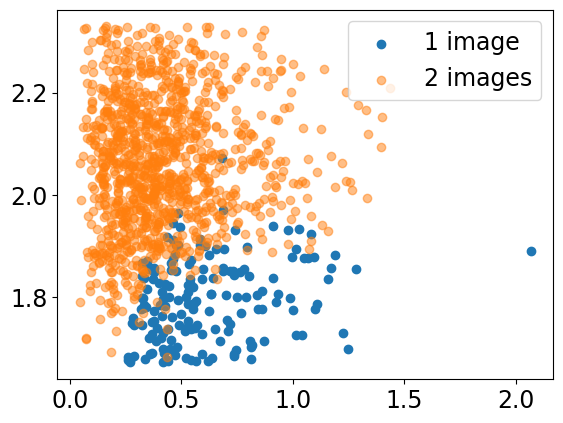

In [144]:
plt.scatter(test_data_1['distance_from_lens'], test_data_1['main_deflector_parameters_gamma'], label='1 image')
plt.scatter(test_data_2['distance_from_lens'], test_data_2['main_deflector_parameters_gamma'], label='2 images', alpha=0.5)
plt.legend()

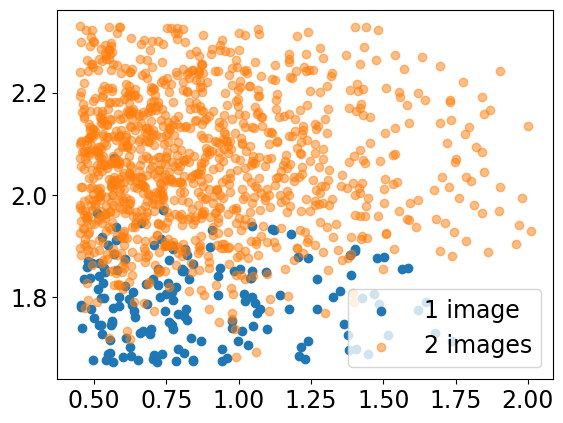

In [145]:
plt.scatter(test_data_1['main_deflector_parameters_theta_E'], test_data_1['main_deflector_parameters_gamma'], label='1 image')
plt.scatter(test_data_2['main_deflector_parameters_theta_E'], test_data_2['main_deflector_parameters_gamma'], label='2 images', alpha=0.5)
plt.legend()

In [146]:
# source_pa = ['distance_from_lens', 'source_parameters_mag_app', 'point_source_parameters_mag_app']
# label_src = dict(zip(source_pa, ['|src-lens|', '$m_{host}$', '$m_{AGN}$']))

In [147]:
# fig, ax = plt.subplots(1, 3, figsize=(18, 6))
# ax = ax.flatten()
# j = 0
# for i in source_pa:
#     _, bins, _ = ax[j].hist(train_data[i], density=True, label='Train', bins=100)
#     ax[j].hist(valid_data[i][n_ind], density=True, alpha=0.7, label='10% Highest Loss', bins=bins)
#     ax[j].scatter(valid_data[i][n_ind5],[0.1]*len(n_ind5), s=20, color='r', marker='*', alpha=0.4, label='10 Highest Loss')

#     ax[j].set_title(label_src[i])
#     j+=1
#     # ax[j].legend()
# plt.legend()
# #plt.suptitle("Distribution of parameters for images with high loss, compared to training prior")

In [148]:
# fig, ax = plt.subplots(2, 4, figsize=(16, 8))
# ax = ax.flatten()
# j = 0
# for i in interesting:
#     _, bins, _ = ax[j].hist(train_data[i], density=True, label='Train', bins=100)
#     ax[j].hist(valid_data[i][n_ind], density=True, alpha=0.5, label='10% Highest Loss', bins=bins)
#     ax[j].scatter(valid_data[i][n_ind5],[0.1]*len(n_ind5), s=20, color='r', marker='*', alpha=0.4, label='10 Highest Loss')
#     ax[j].set_title(label[i])
#     j+=1
#     # ax[j].legend()
# plt.legend()
# plt.suptitle("Distribution of parameters for images with high loss, compared to training prior")

In [149]:
# plt.scatter(valid_data['point_source_parameters_z_point_source'], valid_data['point_source_parameters_mag_app'],s=10,alpha=0.9, label='train')
# plt.scatter(valid_data['point_source_parameters_z_point_source'][n_ind], valid_data['point_source_parameters_mag_app'][n_ind], s=10, alpha=0.3, label='high loss')

# plt.scatter(valid_data['point_source_parameters_z_point_source'][n_ind5], valid_data['point_source_parameters_mag_app'][n_ind5], s=20, alpha=1,color='r',marker='*', label='top 10 loss')
# plt.xlabel("Redshift")
# plt.ylabel("Apparent Magnitude of AGN")
# plt.legend()

In [150]:
# bigloss = np.where(img_losses>1e10)[0]
# wanted = np.random.choice(np.arange(1e5), 20)
# fig,ax=plt.subplots(4, 5, figsize=(25, 20))
# ax=ax.flatten()
# i = 0
# for ind in wanted:
# #for ind in [6887]:
#     name = '%07d'%(ind)
#     img = np.load(f'generated_images/no_lens/config_LSST/image_{name}.npy')

#     print('max: ', np.max(img))

#     imgtf = tf.convert_to_tensor(img.reshape(1, 33,33, 1))
#     #imgloss = trained.loss_single_image (y_test[ind, :], imgtf)
#     ax[i].imshow(img, norm='asinh')
#     ax[i].set_title(f'{ind}' )
#     ax[i].axis('off')
#     i+=1
#         #

In [151]:
# bigloss = np.random.choice(np.where(img_losses>1e10)[0], 20)
# wanted = np.random.choice(np.arange(1e5), 20)
# fig,ax=plt.subplots(4, 5, figsize=(25, 20))
# ax=ax.flatten()
# i = 0
# for ind in bigloss:
# #for ind in [6887]:
#     name = '%07d'%(ind)
#     img = np.load(f'generated_images/no_lens_valid/config_LSST/image_{name}.npy')

#     print('max of im: ', np.max(img))

#     imgtf = tf.convert_to_tensor(img.reshape(1, 33,33, 1))
#     imgloss = trained.loss_single_image (y_test[ind, :], imgtf)
#     ax[i].imshow(img, norm='asinh')
#     ax[i].set_title(f'{ind}' )
#     ax[i].axis('off')
#     i+=1
#         #

In [116]:
from matplotlib.animation import FFMpegWriter


KeyboardInterrupt: 

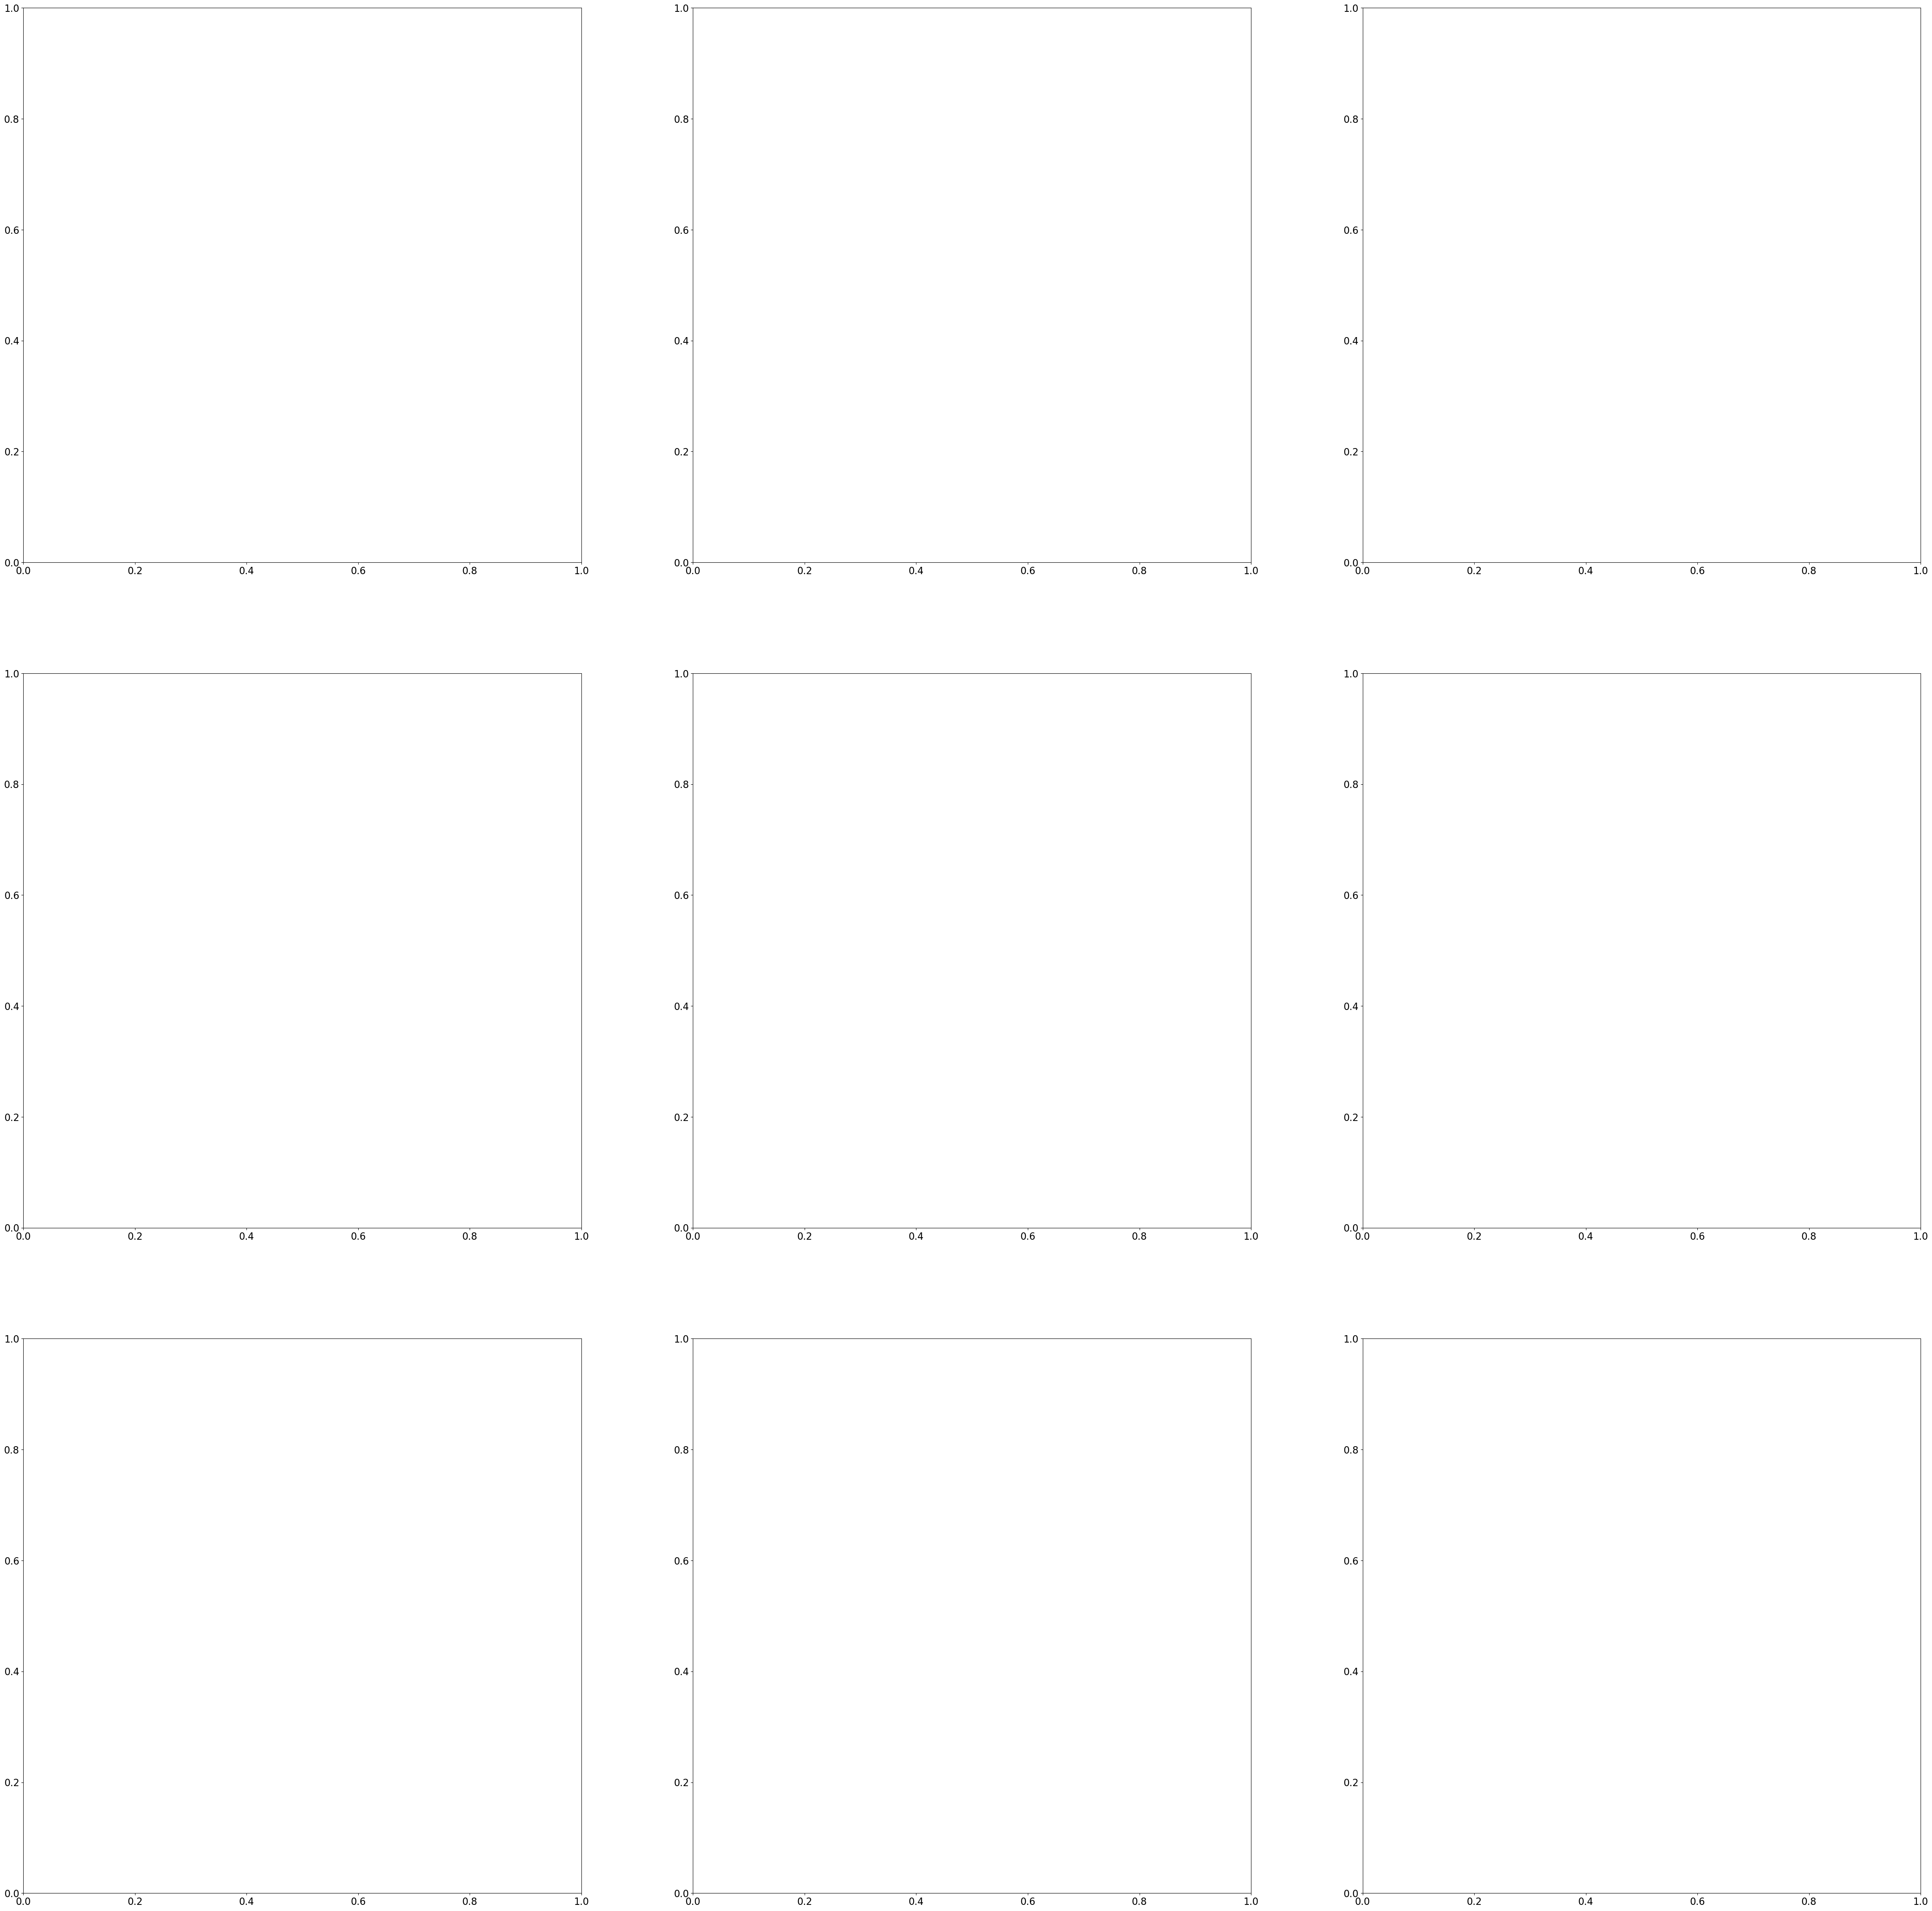

In [66]:
metadata = dict(title='Training Progress', artist='Matplotlib',comment='learning from LSST data')
writer = FFMpegWriter(fps=4, metadata=metadata)
#ax[0].set_ylim(-3,3)
fig, ax = plt.subplots(3, 3, figsize=(60,60))

ax = ax.flatten()
props1 = dict(boxstyle='round', facecolor='turquoise', alpha=0.5)
props2 = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
props3 = dict(boxstyle='round', facecolor='thistle', alpha=0.5)


with writer.saving(fig, "test.mp4", dpi=200):
    for file in files:
        trained = network_predictions.NetworkPredictions(path_to_model_weights=file,
                                                 path_to_model_norms=path_to_norms,
                                                 learning_params=None,
                                                 loss_type='diag',
                                                 model_type='xresnet34',
                                                 norm_type='norm')
        

        with io.capture_output() as captured:

            y_test, y_pred, std_pred, prec_pred = trained.gen_network_predictions('generated_images/test/config_LSST_catalog/',samples=False,shuffle=False);
    
        error = y_test - y_pred
        title = re.search(r'-(.*?)_', file).group(0)[1:-1]
        for i in range(y_pred.shape[1]):
            P = np.median(std_pred[:,i])
            ax[i].errorbar(y_test[:,i], y_pred[:,i], fmt='o', mec='indigo', mfc='indigo',marker='s', ms=2, alpha=0.5)
            # ax[i].errorbar(wy_test[:,i], wy_pred[:,i],yerr=wstd_pred[:,i], fmt='o', mfc='r',marker='s', ms=3, alpha=0.3)
            ax[i].plot(y_test[:,i], y_test[:,i], color='gold', lw=3)
            ax[i].set_title(label[trained.learning_params[i]],size=15)
            ax[i].set_xlabel('Truth',size=10)
            ax[i].set_ylabel('Prediction',size=10)
            ax[i].tick_params(axis='both', length=6, which='major', labelsize=8)
            ax[i].tick_params(axis='both', length=6, which='minor', labelsize=8)
            ax[i].set_ylim(ylims_min[i], ylims_max[i])
            ax[i].grid()
        ax[-1].plot()
#fig.suptitle("Individual Lens Parameter Recovery", size=120)
        # fig.tight_layout()
        fig.suptitle(f'Loss = {title}')
        plt.show();
        plt.draw();
        writer.grab_frame();
        plt.pause(0.1);
        for i in range(y_pred.shape[1]):
            ax[i].clear()

In [681]:
# import matplotlib.pyplot as plt

# for i in range(y_pred.shape[1]):
#     fig, ax = plt.subplots(1, 1, figsize=(8,4))
#     # ax.errorbar(wy_test[:,i], wy_test[:,i] - wy_pred[:,i], yerr=wstd_pred[:,i], mec='g',fmt='o', ecolor='g',ms=5, mfc='k', label='$\sigma $')
#     # ax.plot(y_test[:,i], y_test[:,i], color='r')
#     sigma_arr = np.abs((wy_test[:,i] - wy_pred[:,i])/wstd_pred[:,i])
#     error_small = np.abs(y_test[:,i] - y_pred[:,i]).argsort()[:500]
#     error_small_post = (std_pred[:,i][error_small]).argsort()[:100]

#     error_big = np.abs(y_test[:,i] - y_pred[:,i]).argsort()[-500:]
#     error_big_post = (std_pred[:,i][error_big]).argsort()[-100:]
    
#     ax.scatter(wy_test[:,i] - wy_pred[:,i],wstd_pred[:,i],s=10 ,c='k', label='Epoch:2')
#     ax.scatter(y_test[:,i] - y_pred[:,i],std_pred[:,i],s=10, c='b', alpha = 0.5,label='Epoch:34')
#     # ax.scatter((wy_test[:,i] - wy_pred[:,i])[max_sigma_idx],wstd_pred[:,i][max_sigma_idx],c='y',s=10 )
#     ax.scatter((y_test[:,i] - y_pred[:,i])[error_small_post],std_pred[:,i][error_small_post],c='r',s=10, label='Worst Points')
#     ax.scatter((y_test[:,i] - y_pred[:,i])[error_big_post],std_pred[:,i][error_big_post],c='g',s=10, label='Best Points')
    
#     ax.set_title(label[trained.learning_params[i]])
#     ax.set_xlabel('Error')
#     ax.set_ylabel('Posterior Width', size=20)
#     fig.tight_layout()
    
#     plt.show()

In [682]:
# fig, ax = plt.subplots(4, 2, figsize=(25, 25))
# ax = ax.flatten()
# for i in range(y_pred.shape[1]):
#     error = (y_test[:, i] - y_pred[:, i])/std_pred[:,i]
#     werror = (wy_test[:, i] - wy_pred[:, i])/wstd_pred[:,i]
#     ax[i].hist(error, bins=200, label='Epoch:50', color='g', alpha=0.5, density=True)
#     ax[i].hist(werror, bins=200, label='Epoch: 2', color='r', alpha=0.5, density=True)
#     redline, wredline =np.mean(error), np.mean(werror)
#     rounded = np.round(redline, 3)
#     ax[i].axvline(redline,ls='--', color='g')
#     ax[i].axvline(wredline,ls='--', color='r')

#     ax[i].set_title(label[trained.learning_params[i]], size=50)
#     ax[i].set_xlabel('$(truth - predicted)/ \sigma$', size=50)
#     ax[i].legend()
#     ax[i].set_xlim(-5,5)
# fig.tight_layout()

In [683]:
# plt.hist(y_pred[:,0], bins=100, label='True', density=True)
# np.min(y_pred[:,0])
# plt.hist(y_test[:,0], alpha=0.5,bins=100,  label = 'Predicted', density=True)
# np.min(y_test[:,0])
# plt.legend();
# plt.title("Einstein Radius Predictions")